<a href="https://colab.research.google.com/github/binxni/Machine-Learning/blob/main/Team_1_Code_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from tqdm.auto import tqdm
from PIL import Image

BATCH_SIZE = 64

# L1 정규화 함수 정의
def l1_regularization(model, lambda_l1):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return lambda_l1 * l1_norm

lambda_l1 = 0.0001  # L1 정규화 강도

# 1. Pre-training 단계

# 원본 데이터셋에 적용할 변환
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 증강된 데이터셋에 적용할 변환
augmented_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 원본 CIFAR-100 데이터셋 로드
basic_dataset = datasets.CIFAR100(root="/data/", train=True, download=True, transform=basic_transform)

# 증강된 CIFAR-100 데이터셋 로드
augmented_dataset = datasets.CIFAR100(root="/data/", train=True, download=True, transform=augmented_transform)

# 원본과 증강된 데이터셋을 결합
combined_dataset = ConcatDataset([basic_dataset, augmented_dataset])

# 데이터 로더 생성
cifar100_train_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# ResNet-18 모델 로드 및 수정 (CIFAR-100에 맞춤)
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 100)  # CIFAR-100에 맞춘 출력층

device = torch.device('cuda:1')
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.to(device)

for i, data in enumerate(tqdm(cifar100_train_loader)):
    inputs, targets = data[0].to(device), data[1].to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)



def train_model_with_early_stopping(model, train_loader, criterion, optimizer, lambda_l1, num_epochs=100, patience=5, scheduler=None):
    model.train()
    loss_list = []
    acc_list = []
    best_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(num_epochs):
        loss_total = 0.0
        correct_total = 0
        n_iter = 0

        for i, data in enumerate(tqdm(train_loader)):
            inputs, targets = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # L1 정규화 손실 추가
            l1_loss = l1_regularization(model, lambda_l1)
            total_loss = loss + l1_loss

            total_loss.backward()
            optimizer.step()

            # 통계 수집
            loss_total += total_loss.item()
            pred = outputs.argmax(dim=-1)
            correct_total += pred.eq(targets).sum().item()
            n_iter += 1

        epoch_loss = loss_total / n_iter
        epoch_acc = correct_total / len(train_loader.dataset)

        loss_list.append(epoch_loss)
        acc_list.append(epoch_acc)

        print(f"Epoch: {epoch+1} - Loss: {epoch_loss:.3f} - Accuracy: {epoch_acc:.3f}")

        # Early Stopping 체크
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

        # 학습률 스케줄러 업데이트
        if scheduler:
            scheduler.step()

    return loss_list, acc_list

# CIFAR-100에 대한 Pre-training
print("Training on CIFAR-100 dataset with L1 regularization and data augmentation...")





/home/user/anaconda3/envs/kh_ai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1563/1563 [01:46<00:00, 14.66it/s]

Training on CIFAR-100 dataset with L1 regularization and data augmentation...


In [ ]:
train_model_with_early_stopping(model, cifar100_train_loader, criterion, optimizer, lambda_l1, num_epochs=100)

100%|██████████| 1563/1563 [02:08<00:00, 12.15it/s]


Epoch: 1 - Loss: 16.195 - Accuracy: 0.183


100%|██████████| 1563/1563 [02:33<00:00, 10.19it/s]


Epoch: 2 - Loss: 8.739 - Accuracy: 0.323


100%|██████████| 1563/1563 [02:37<00:00,  9.90it/s]


Epoch: 3 - Loss: 6.875 - Accuracy: 0.409


100%|██████████| 1563/1563 [02:06<00:00, 12.37it/s]


Epoch: 4 - Loss: 5.990 - Accuracy: 0.462


100%|██████████| 1563/1563 [02:51<00:00,  9.09it/s]


Epoch: 5 - Loss: 5.425 - Accuracy: 0.505


100%|██████████| 1563/1563 [02:55<00:00,  8.92it/s]


Epoch: 6 - Loss: 5.026 - Accuracy: 0.534


100%|██████████| 1563/1563 [03:18<00:00,  7.88it/s]


Epoch: 7 - Loss: 4.699 - Accuracy: 0.561


100%|██████████| 1563/1563 [03:04<00:00,  8.48it/s]


Epoch: 8 - Loss: 4.453 - Accuracy: 0.581


100%|██████████| 1563/1563 [03:08<00:00,  8.27it/s]


Epoch: 9 - Loss: 4.247 - Accuracy: 0.600


100%|██████████| 1563/1563 [03:04<00:00,  8.45it/s]


Epoch: 10 - Loss: 4.058 - Accuracy: 0.617


100%|██████████| 1563/1563 [03:02<00:00,  8.57it/s]


Epoch: 11 - Loss: 3.896 - Accuracy: 0.631


100%|██████████| 1563/1563 [03:06<00:00,  8.39it/s]


Epoch: 13 - Loss: 3.614 - Accuracy: 0.657


100%|██████████| 1563/1563 [03:05<00:00,  8.42it/s]


Epoch: 14 - Loss: 3.504 - Accuracy: 0.666


100%|██████████| 1563/1563 [02:38<00:00,  9.89it/s]


Epoch: 15 - Loss: 3.409 - Accuracy: 0.677


100%|██████████| 1563/1563 [02:34<00:00, 10.13it/s]


Epoch: 16 - Loss: 3.315 - Accuracy: 0.688


100%|██████████| 1563/1563 [02:37<00:00,  9.95it/s]


Epoch: 17 - Loss: 3.242 - Accuracy: 0.694


100%|██████████| 1563/1563 [02:36<00:00,  9.96it/s]


Epoch: 18 - Loss: 3.174 - Accuracy: 0.704


100%|██████████| 1563/1563 [02:36<00:00,  9.97it/s]


Epoch: 19 - Loss: 3.103 - Accuracy: 0.712


100%|██████████| 1563/1563 [02:40<00:00,  9.72it/s]


Epoch: 20 - Loss: 3.051 - Accuracy: 0.715


100%|██████████| 1563/1563 [02:09<00:00, 12.09it/s]


Epoch: 21 - Loss: 2.992 - Accuracy: 0.725


100%|██████████| 1563/1563 [01:42<00:00, 15.23it/s]


Epoch: 22 - Loss: 2.943 - Accuracy: 0.731


100%|██████████| 1563/1563 [01:42<00:00, 15.23it/s]


Epoch: 23 - Loss: 2.889 - Accuracy: 0.737


100%|██████████| 1563/1563 [01:42<00:00, 15.23it/s]


Epoch: 24 - Loss: 2.849 - Accuracy: 0.744


100%|██████████| 1563/1563 [01:42<00:00, 15.26it/s]


Epoch: 25 - Loss: 2.806 - Accuracy: 0.749


100%|██████████| 1563/1563 [01:42<00:00, 15.22it/s]


Epoch: 26 - Loss: 2.764 - Accuracy: 0.755


100%|██████████| 1563/1563 [01:42<00:00, 15.22it/s]


Epoch: 27 - Loss: 2.733 - Accuracy: 0.759


100%|██████████| 1563/1563 [01:42<00:00, 15.24it/s]


Epoch: 28 - Loss: 2.695 - Accuracy: 0.764


100%|██████████| 1563/1563 [01:42<00:00, 15.24it/s]


Epoch: 29 - Loss: 2.667 - Accuracy: 0.769


100%|██████████| 1563/1563 [01:42<00:00, 15.30it/s]


Epoch: 30 - Loss: 2.636 - Accuracy: 0.774


100%|██████████| 1563/1563 [01:42<00:00, 15.24it/s]


Epoch: 31 - Loss: 2.606 - Accuracy: 0.778


100%|██████████| 1563/1563 [01:42<00:00, 15.23it/s]


Epoch: 32 - Loss: 2.579 - Accuracy: 0.782


100%|██████████| 1563/1563 [01:42<00:00, 15.25it/s]


Epoch: 35 - Loss: 2.505 - Accuracy: 0.793


100%|██████████| 1563/1563 [01:43<00:00, 15.16it/s]


Epoch: 36 - Loss: 2.484 - Accuracy: 0.796


100%|██████████| 1563/1563 [01:42<00:00, 15.25it/s]


Epoch: 37 - Loss: 2.463 - Accuracy: 0.799


100%|██████████| 1563/1563 [01:42<00:00, 15.20it/s]


Epoch: 38 - Loss: 2.444 - Accuracy: 0.802


100%|██████████| 1563/1563 [01:42<00:00, 15.22it/s]


Epoch: 39 - Loss: 2.423 - Accuracy: 0.806


100%|██████████| 1563/1563 [01:42<00:00, 15.19it/s]


Epoch: 40 - Loss: 2.400 - Accuracy: 0.809


100%|██████████| 1563/1563 [01:43<00:00, 15.09it/s]


Epoch: 41 - Loss: 2.385 - Accuracy: 0.811


100%|██████████| 1563/1563 [01:44<00:00, 14.89it/s]


Epoch: 42 - Loss: 2.360 - Accuracy: 0.815


100%|██████████| 1563/1563 [01:46<00:00, 14.64it/s]


Epoch: 43 - Loss: 2.343 - Accuracy: 0.818


100%|██████████| 1563/1563 [01:49<00:00, 14.30it/s]


Epoch: 49 - Loss: 2.247 - Accuracy: 0.830


100%|██████████| 1563/1563 [01:48<00:00, 14.36it/s]


Epoch: 50 - Loss: 2.233 - Accuracy: 0.832


100%|██████████| 1563/1563 [01:49<00:00, 14.25it/s]


Epoch: 51 - Loss: 2.217 - Accuracy: 0.832


100%|██████████| 1563/1563 [01:49<00:00, 14.32it/s]


Epoch: 52 - Loss: 2.207 - Accuracy: 0.833


100%|██████████| 1563/1563 [01:48<00:00, 14.38it/s]


Epoch: 53 - Loss: 2.186 - Accuracy: 0.839


100%|██████████| 1563/1563 [01:49<00:00, 14.26it/s]


Epoch: 54 - Loss: 2.177 - Accuracy: 0.840


100%|██████████| 1563/1563 [01:48<00:00, 14.45it/s]


Epoch: 55 - Loss: 2.164 - Accuracy: 0.840


100%|██████████| 1563/1563 [01:48<00:00, 14.40it/s]


Epoch: 56 - Loss: 2.147 - Accuracy: 0.843


100%|██████████| 1563/1563 [01:49<00:00, 14.28it/s]


Epoch: 57 - Loss: 2.142 - Accuracy: 0.842


100%|██████████| 1563/1563 [01:48<00:00, 14.41it/s]


Epoch: 58 - Loss: 2.126 - Accuracy: 0.844


 77%|███████▋  | 1207/1563 [01:23<00:24, 14.65it/s]

In [ ]:
torch.save(model, '/data/cifar100_full_model_2.pth')

# 2. Fine-tuning 단계에서 모델 불러오기
model = torch.load('/data/cifar100_full_model_2.pth')

/tmp/ipykernel_572738/2496417660.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/home/Data_Drive_8TB_3/ch2860/pytorch/cifar100_full_model_2.pth')


<!-- # 데이터 증강 강화 (Fine-tuning 시)
cub_bird_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

cub_train_dataset = CUB_Dataset(img_file="/home/Data_Drive_8TB_3/ch2860/pytorch/CUB_train_images.npy",
                                label_file="/home/Data_Drive_8TB_3/ch2860/pytorch/CUB_train_labels.npy", transform=cub_bird_transform)
cub_train_loader = torch.utils.data.DataLoader(cub_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
 -->

In [ ]:
# Gaussian 노이즈 추가를 위한 클래스
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

# CUB-200 데이터셋 로드 클래스
class CUB200Dataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = np.load(images_path)
        self.labels = np.load(labels_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # 데이터 타입을 uint8로 변환
        image = (image * 255).astype(np.uint8)  # 이미지를 [0, 255] 범위로 변환

        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label




# 기본 변환 (원본 이미지에만 적용)
transform_original = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# 각 증강 기법을 적용한 변환들
transform_flip = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),  # 항상 수평 뒤집기
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_rotation = transforms.Compose([
    transforms.RandomRotation(15),  # 15도 내에서 회전
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_color_jitter = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_random_resized_crop = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_random_grayscale = transforms.Compose([
    transforms.RandomGrayscale(p=1.0),  # 그레이스케일 적용
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_gaussian_noise = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(mean=0.0, std=0.1),  # 표준편차 0.1로 가우시안 노이즈 추가
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


# 데이터셋 로드
original_dataset = CUB200Dataset('/data/CUB_train_images.npy', '/data/CUB_train_labels.npy', transform=transform_original)
flip_dataset = CUB200Dataset('/data/CUB_train_images.npy', '/data/CUB_train_labels.npy', transform=transform_flip)
rotation_dataset = CUB200Dataset('/data/CUB_train_images.npy', '/data/CUB_train_labels.npy', transform=transform_rotation)
color_jitter_dataset = CUB200Dataset('/data/CUB_train_images.npy', '/data/CUB_train_labels.npy', transform=transform_color_jitter)
random_resized_crop_dataset = CUB200Dataset('/data/CUB_train_images.npy', '/data/CUB_train_labels.npy', transform=transform_random_resized_crop)
random_grayscale_dataset = CUB200Dataset('/data/CUB_train_images.npy', '/data/CUB_train_labels.npy', transform=transform_random_grayscale)
gaussian_noise_dataset = CUB200Dataset('/data/CUB_train_images.npy', '/data/CUB_train_labels.npy', transform=transform_gaussian_noise)

# 여러 데이터셋을 결합
combined_dataset = ConcatDataset([original_dataset, flip_dataset, rotation_dataset, color_jitter_dataset, random_resized_crop_dataset, random_grayscale_dataset, gaussian_noise_dataset])

# DataLoader 생성
train_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True, num_workers=4)


In [ ]:
# DataLoader 생성
cub_train_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True, num_workers=4)

In [ ]:
class CUB_Dataset(Dataset):
    def __init__(self, img_file, label_file, transform=None):
        self.img = np.load(img_file)
        self.labels = np.load(label_file)
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        image = self.img[idx]
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label


cub_bird_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


cub_val_dataset = CUB_Dataset(img_file="/data/CUB_val_images.npy",
                              label_file="/data/CUB_val_labels.npy", transform=cub_bird_transform)
cub_val_loader = torch.utils.data.DataLoader(cub_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


In [ ]:
# Pre-training 단계에서 저장된 모델 가중치를 불러오기
pretrained_model = torch.load('/data/cifar100_full_model.pth')
pretrained_model = pretrained_model.to('cuda:1')

# Fine-tuning을 위해 새로운 모델 정의 (Dropout 추가)
class ModifiedResNet18(nn.Module):
    def __init__(self, pretrained_model, num_classes=200):
        super(ModifiedResNet18, self).__init__()
        self.model = pretrained_model
        # pretrained_model.fc는 nn.Linear로 정의되어 있으므로 직접 접근
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.3),  # Dropout 추가
            nn.Linear(in_features, num_classes)  # CUB-200에 맞춘 출력층
        )

    def forward(self, x):
        return self.model(x)

# Fine-tuning을 위한 모델 정의 및 준비
model = ModifiedResNet18(pretrained_model=pretrained_model, num_classes=200)

device = torch.device('cuda:1')
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.to(device)

for i, data in enumerate(tqdm(cub_train_loader)):
    inputs, targets = data[0].to(device), data[1].to(device)


/tmp/ipykernel_572738/475163752.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model = torch.load('/home/Data_Drive_8TB_3/ch2860/pytorch/cifar100_full_model

In [ ]:
# Optimizer와 Learning Rate Scheduler 설정
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Fine-tuning 수행
print("Fine-tuning on CUB-200 dataset with data augmentation, dropout, and learning rate scheduling...")
loss_list, acc_list =  train_model_with_early_stopping(model, cub_train_loader, criterion, optimizer, lambda_l1, num_epochs=25)


Fine-tuning on CUB-200 dataset with data augmentation, dropout, and learning rate scheduling...


100%|██████████| 656/656 [00:44<00:00, 14.77it/s]


Epoch: 1 - Loss: 5.504 - Accuracy: 0.191


100%|██████████| 656/656 [00:44<00:00, 14.62it/s]


Epoch: 2 - Loss: 3.807 - Accuracy: 0.553


100%|██████████| 656/656 [00:43<00:00, 15.05it/s]


Epoch: 3 - Loss: 2.886 - Accuracy: 0.781


100%|██████████| 656/656 [00:43<00:00, 15.12it/s]


Epoch: 4 - Loss: 2.420 - Accuracy: 0.876


100%|██████████| 656/656 [00:43<00:00, 15.15it/s]


Epoch: 5 - Loss: 2.188 - Accuracy: 0.921


100%|██████████| 656/656 [00:42<00:00, 15.28it/s]


Epoch: 6 - Loss: 2.052 - Accuracy: 0.940


100%|██████████| 656/656 [00:43<00:00, 15.18it/s]


Epoch: 7 - Loss: 1.977 - Accuracy: 0.948


100%|██████████| 656/656 [00:44<00:00, 14.81it/s]


Epoch: 8 - Loss: 1.922 - Accuracy: 0.956


100%|██████████| 656/656 [00:43<00:00, 14.94it/s]


Epoch: 9 - Loss: 1.882 - Accuracy: 0.957


100%|██████████| 656/656 [00:43<00:00, 15.12it/s]


Epoch: 10 - Loss: 1.859 - Accuracy: 0.958


100%|██████████| 656/656 [00:43<00:00, 15.09it/s]


Epoch: 11 - Loss: 1.826 - Accuracy: 0.961


100%|██████████| 656/656 [00:42<00:00, 15.27it/s]


Epoch: 12 - Loss: 1.797 - Accuracy: 0.962


100%|██████████| 656/656 [00:43<00:00, 15.19it/s]


Epoch: 13 - Loss: 1.766 - Accuracy: 0.964


100%|██████████| 656/656 [00:43<00:00, 15.26it/s]


Epoch: 14 - Loss: 1.766 - Accuracy: 0.962


100%|██████████| 656/656 [00:42<00:00, 15.30it/s]


Epoch: 15 - Loss: 1.713 - Accuracy: 0.971


100%|██████████| 656/656 [00:43<00:00, 15.11it/s]


Epoch: 16 - Loss: 1.730 - Accuracy: 0.963


100%|██████████| 656/656 [00:43<00:00, 15.21it/s]


Epoch: 17 - Loss: 1.707 - Accuracy: 0.965


100%|██████████| 656/656 [00:43<00:00, 15.15it/s]


Epoch: 18 - Loss: 1.684 - Accuracy: 0.967


100%|██████████| 656/656 [00:43<00:00, 15.07it/s]


Epoch: 19 - Loss: 1.671 - Accuracy: 0.966


100%|██████████| 656/656 [00:43<00:00, 15.09it/s]


Epoch: 20 - Loss: 1.659 - Accuracy: 0.967


100%|██████████| 656/656 [00:42<00:00, 15.31it/s]


Epoch: 21 - Loss: 1.645 - Accuracy: 0.967


100%|██████████| 656/656 [00:43<00:00, 15.24it/s]


Epoch: 22 - Loss: 1.637 - Accuracy: 0.968


100%|██████████| 656/656 [00:42<00:00, 15.28it/s]


Epoch: 23 - Loss: 1.613 - Accuracy: 0.970


100%|██████████| 656/656 [00:43<00:00, 15.20it/s]


Epoch: 24 - Loss: 1.613 - Accuracy: 0.967


100%|██████████| 656/656 [00:42<00:00, 15.27it/s]


Epoch: 25 - Loss: 1.609 - Accuracy: 0.967


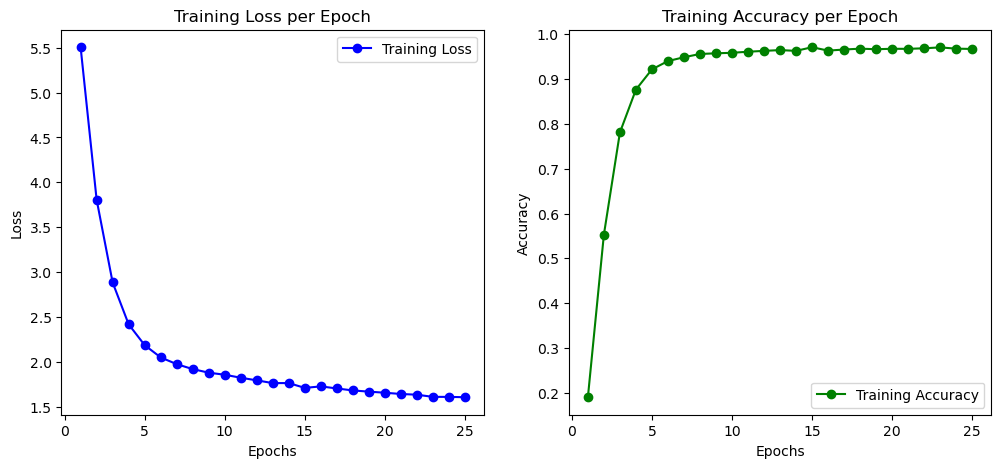

Accuracy of the network on the validation images: 28.55 %


28.546772523299964

In [ ]:

# 학습 손실 및 정확도 시각화
epochs = range(1, len(loss_list) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_list, 'bo-', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc_list, 'go-', label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 모델 평가
evaluate_model(model, cub_val_loader)

In [ ]:
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the validation images: {accuracy:.2f} %')
    return accuracy

evaluate_model(model, cub_val_loader)

Accuracy of the network on the validation images: 28.55 %


28.546772523299964

In [ ]:
class TestDataset(Dataset):
    def __init__(self, img_file, transform=None):
        self.img =np.load(img_file)
        self.transform = transform

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        image = self.img[idx]
        if self.transform is not None:
            image = self.transform(image)

        return image

test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_dataset = TestDataset(img_file="/data/CUB_test_images.npy",transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [ ]:
def test(model, test_loader):
  model.eval()
  test_predictions = []

  with torch.inference_mode():
      for i, data in enumerate(tqdm(test_loader)):
          data = data.float().to(device)
          output = model(data)
          test_predictions.append(output.cpu())

  return torch.cat(test_predictions, dim=0)

In [ ]:
# Save test output npy file
predictions = test(model, test_loader)
np.save('/data/TEAM_1_RESULT', predictions.numpy())

100%|██████████| 46/46 [00:01<00:00, 26.59it/s]
